1. Initial Setup and Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import joblib
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import os
import matplotlib.pyplot as plt
import seaborn as sns

2. Loading Pre-trained Models

In [ ]:
# Load EfficientNetB0 model
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

# Load ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


3. Helper Functions

In [ ]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    return image

In [ ]:
def extract_features_efficientnet(image_paths):
    images = [cv2.resize(load_image(img), (224, 224)) for img in image_paths]
    images = np.array([efficientnet_preprocess_input(img) for img in images])
    features = efficientnet_model.predict(images)
    return features

def extract_features_resnet50(image_paths):
    images = [cv2.resize(load_image(img), (224, 224)) for img in image_paths]
    images = np.array([resnet_preprocess_input(img) for img in images])
    features = resnet_model.predict(images)
    return features

4. Loading the Dataset

In [ ]:
def load_dataset(dataset_path):
    categories = ['Very Good', 'Good', 'Neutral', 'Bad', 'Very Bad']
    image_paths = []
    labels = []

    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        for img_name in os.listdir(category_path):
            image_paths.append(os.path.join(category_path, img_name))
            labels.append(label)

    return image_paths, labels

5. Dataset Paths and Loading Data

In [ ]:
train_dataset_path = '/content/drive/My Drive/projects_data/fyp/Train Set'
test_dataset_path = '/content/drive/My Drive/projects_data/fyp/Test Set'

train_image_paths, train_labels = load_dataset(train_dataset_path)
test_image_paths, test_labels = load_dataset(test_dataset_path)

6. Extracting and Saving Features

In [ ]:
# Extract and save features for training data
train_features_efficientnet = extract_features_efficientnet(train_image_paths)
train_features_resnet50 = extract_features_resnet50(train_image_paths)
train_features = np.hstack((train_features_efficientnet, train_features_resnet50))

75/75 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 471s 6s/step


In [ ]:
# Extract and save features for test data
test_features_efficientnet = extract_features_efficientnet(test_image_paths)
test_features_resnet50 = extract_features_resnet50(test_image_paths)
test_features = np.hstack((test_features_efficientnet, test_features_resnet50))

19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 117s 6s/step


In [ ]:
# Save the features and labels
np.save('train_features.npy', train_features)
np.save('train_labels.npy', train_labels)
np.save('test_features.npy', test_features)
np.save('test_labels.npy', test_labels)

7. Hyperparameter Tuning and Training the Model

In [ ]:
# Load the features and labels
train_features = np.load('train_features.npy')
train_labels = np.load('train_labels.npy')

# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Train Random Forest classifier
rf_ensemble = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_ensemble, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(train_features, train_labels)

rf_ensemble = grid_search.best_estimator_

# Save the trained Random Forest ensemble model
joblib.dump(rf_ensemble, '/content/drive/My Drive/projects_data/fyp/rf_ensemble_model_1.pkl')

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


['/content/drive/My Drive/projects_data/fyp/rf_ensemble_model_1.pkl']

8. Model Evaluation

In [ ]:
# Make predictions on the test data
predictions = rf_ensemble.predict(test_features)

# Evaluate the model
accuracy = accuracy_score(test_labels, predictions)
report = classification_report(test_labels, predictions, target_names=['Very Good', 'Good', 'Neutral', 'Bad', 'Very Bad'])
cm = confusion_matrix(test_labels, predictions)

print(f'Ensemble Model Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

Ensemble Model Accuracy: 0.7216666666666667
Classification Report:
              precision    recall  f1-score   support

   Very Good       0.72      0.72      0.72       120
        Good       0.73      0.76      0.74       120
     Neutral       0.69      0.84      0.76       120
         Bad       0.71      0.53      0.61       120
    Very Bad       0.76      0.76      0.76       120

    accuracy                           0.72       600
   macro avg       0.72      0.72      0.72       600
weighted avg       0.72      0.72      0.72       600



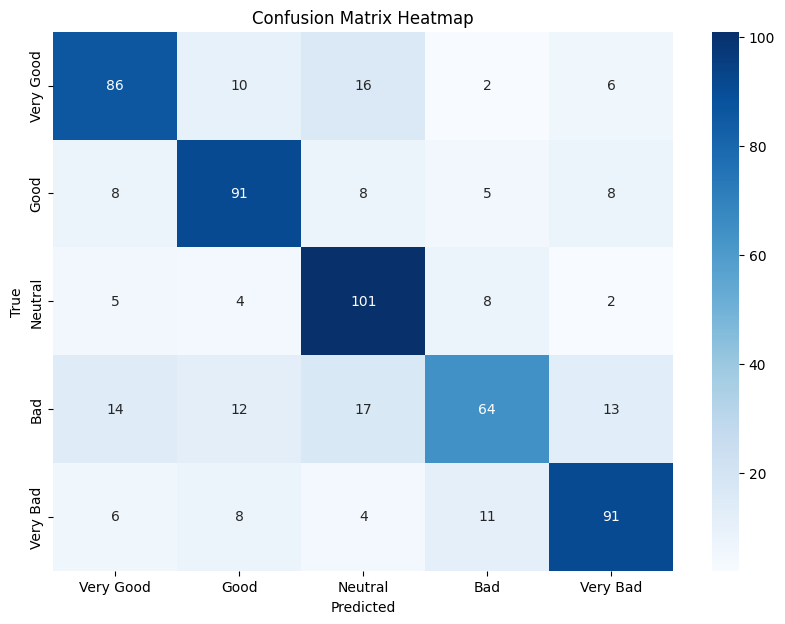

In [ ]:
# Plot confusion matrix heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Very Good', 'Good', 'Neutral', 'Bad', 'Very Bad'], yticklabels=['Very Good', 'Good', 'Neutral', 'Bad', 'Very Bad'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

9. Testing Individual Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import joblib
import numpy as np
import tensorflow
import pickle
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
import cv2

# Load the trained Random Forest ensemble model
rf_ensemble = joblib.load('/content/drive/My Drive/projects_data/fyp/rf_ensemble_model_1.pkl')

Mounted at /content/drive


In [ ]:

efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def load_image(image_path):
    # Load an image from the specified path
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    return img

def test_individual_image(image_path):
    # Extract features from the image
    img = load_image(image_path)
    img_efficientnet = efficientnet_preprocess_input(cv2.resize(img, (224, 224)))
    img_resnet50 = resnet_preprocess_input(cv2.resize(img, (224, 224)))

    feature_efficientnet = efficientnet_model.predict(np.expand_dims(img_efficientnet, axis=0))
    feature_resnet50 = resnet_model.predict(np.expand_dims(img_resnet50, axis=0))

    feature = np.hstack((feature_efficientnet, feature_resnet50))

    # Predict the category
    prediction = rf_ensemble.predict(feature)
    categories = ['Very Good', 'Good', 'Neutral', 'Bad', 'Very Bad']
    predicted_category = categories[prediction[0]]
    return predicted_category

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# testing individual images
test_image_path = '/content/drive/My Drive/projects_data/fyp/Test Set/Very Good/209.jpeg'
predicted_category = test_individual_image(test_image_path)
print(f'The predicted category for the test image is: {predicted_category}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
The predicted category for the test image is: Very Good
